# Reverse-engineering SAE features in GELU-2L with transcoders

# Setup

## Dependencies

In [70]:
import transformer_lens
from transformer_lens import HookedTransformer, utils
import torch
import numpy as np
import pprint
import json
import torch.nn as nn
import torch.nn.functional as F
from datasets import load_dataset
from huggingface_hub import HfApi
from IPython.display import HTML
from functools import partial
import tqdm.notebook as tqdm
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'stix'

## Load model

In [4]:
from sae_training.sparse_autoencoder import SparseAutoencoder
from sae_training.utils import LMSparseAutoencoderSessionloader

In [5]:
model = HookedTransformer.from_pretrained('gelu-2l')

Loaded pretrained model gelu-2l into HookedTransformer


## Loading Data

In [7]:
import einops
def tokenize_and_concatenate(
    dataset,
    tokenizer,
    streaming = False,
    max_length = 1024,
    column_name = "text",
    add_bos_token = True,
):
    """Helper function to tokenizer and concatenate a dataset of text. This converts the text to tokens, concatenates them (separated by EOS tokens) and then reshapes them into a 2D array of shape (____, sequence_length), dropping the last batch. Tokenizers are much faster if parallelised, so we chop the string into 20, feed it into the tokenizer, in parallel with padding, then remove padding at the end.

    This tokenization is useful for training language models, as it allows us to efficiently train on a large corpus of text of varying lengths (without, eg, a lot of truncation or padding). Further, for models with absolute positional encodings, this avoids privileging early tokens (eg, news articles often begin with CNN, and models may learn to use early positional encodings to predict these)

    Args:
        dataset (Dataset): The dataset to tokenize, assumed to be a HuggingFace text dataset.
        tokenizer (AutoTokenizer): The tokenizer. Assumed to have a bos_token_id and an eos_token_id.
        streaming (bool, optional): Whether the dataset is being streamed. If True, avoids using parallelism. Defaults to False.
        max_length (int, optional): The length of the context window of the sequence. Defaults to 1024.
        column_name (str, optional): The name of the text column in the dataset. Defaults to 'text'.
        add_bos_token (bool, optional): . Defaults to True.

    Returns:
        Dataset: Returns the tokenized dataset, as a dataset of tensors, with a single column called "tokens"

    Note: There is a bug when inputting very small datasets (eg, <1 batch per process) where it just outputs nothing. I'm not super sure why
    """
    for key in dataset.features:
        if key != column_name:
            dataset = dataset.remove_columns(key)

    if tokenizer.pad_token is None:
        # We add a padding token, purely to implement the tokenizer. This will be removed before inputting tokens to the model, so we do not need to increment d_vocab in the model.
        tokenizer.add_special_tokens({"pad_token": "<PAD>"})
    # Define the length to chop things up into - leaving space for a bos_token if required
    if add_bos_token:
        seq_len = max_length - 1
    else:
        seq_len = max_length

    def tokenize_function(examples):
        text = examples[column_name]
        # Concatenate it all into an enormous string, separated by eos_tokens
        full_text = tokenizer.eos_token.join(text)
        # Divide into 20 chunks of ~ equal length
        num_chunks = 20
        chunk_length = (len(full_text) - 1) // num_chunks + 1
        chunks = [
            full_text[i * chunk_length : (i + 1) * chunk_length]
            for i in range(num_chunks)
        ]
        # Tokenize the chunks in parallel. Uses NumPy because HuggingFace map doesn't want tensors returned
        tokens = tokenizer(chunks, return_tensors="np", padding=True)[
            "input_ids"
        ].flatten()
        # Drop padding tokens
        tokens = tokens[tokens != tokenizer.pad_token_id]
        num_tokens = len(tokens)
        num_batches = num_tokens // (seq_len)
        # Drop the final tokens if not enough to make a full sequence
        tokens = tokens[: seq_len * num_batches]
        tokens = einops.rearrange(
            tokens, "(batch seq) -> batch seq", batch=num_batches, seq=seq_len
        )
        if add_bos_token:
            prefix = np.full((num_batches, 1), tokenizer.bos_token_id)
            tokens = np.concatenate([prefix, tokens], axis=1)
        return {"tokens": tokens}

    tokenized_dataset = dataset.map(
        tokenize_function,
        batched=True,
        remove_columns=[column_name],
    )
    #tokenized_dataset.set_format(type="torch", columns=["tokens"])
    return tokenized_dataset


In [8]:
dataset = load_dataset('Skylion007/openwebtext', split='train', streaming=True)
dataset = dataset.shuffle(seed=42, buffer_size=10_000)
tokenized_owt = tokenize_and_concatenate(dataset, model.tokenizer, max_length=128, streaming=True)
tokenized_owt = tokenized_owt.shuffle(42)
tokenized_owt = tokenized_owt.take(12800*2)
owt_tokens = np.stack([x['tokens'] for x in tokenized_owt])

In [9]:
owt_tokens_torch = torch.from_numpy(owt_tokens).cuda()

## Feature scores

In [10]:
def get_feature_scores(model, encoder, tokens_arr, feature_idx, batch_size=64, act_name='resid_pre', layer=0, use_raw_scores=False, use_decoder=False, feature_post=None, ignore_endoftext=False):
  act_name = encoder.cfg.hook_point
  layer = encoder.cfg.hook_point_layer
    
  scores = []
  endoftext_token = model.to_single_token('<|EOS|>')
  for i in tqdm.tqdm(range(0, tokens_arr.shape[0], batch_size)):
    #print(i, tokens_arr.shape[0], batch_size)
    with torch.no_grad():
      _, cache = model.run_with_cache(tokens_arr[i:i+batch_size], stop_at_layer=layer+1, names_filter=[
        act_name#utils.get_act_name(act_name, layer)
      ])
      mlp_acts = cache[act_name]#utils.get_act_name(act_name, layer)]
      mlp_acts_flattened = mlp_acts.reshape(-1, encoder.W_enc.shape[0])
      if feature_post is None:
        feature_post = encoder.W_enc[:, feature_idx] if not use_decoder else encoder.W_dec[feature_idx]
      bias = -(encoder.b_dec @ feature_post) if use_decoder else encoder.b_enc[feature_idx] - (encoder.b_dec @ feature_post)
      if use_raw_scores:
        cur_scores = (mlp_acts_flattened @ feature_post) + bias
      else:
        _, hidden_acts, _, _, _, _ = encoder(mlp_acts_flattened)
        cur_scores = hidden_acts[:, feature_idx]
      if ignore_endoftext:
          cur_scores[tokens_arr[i:i+batch_size].reshape(-1) == endoftext_token] = -torch.inf
    scores.append(utils.to_numpy(cur_scores.reshape(-1, tokens_arr.shape[1])).astype(np.float16))
  return np.concatenate(scores)

In [11]:
def sample_percentiles(arr, num_samples):
    sample_idxs = []
    sample_vals = []
    
    num_samples = num_samples - 1
    p_step = 100./num_samples
    
    for p in np.arange(0,100,p_step):
        value_at_p = np.percentile(arr.reshape(-1), p, interpolation='nearest')
        p_idx = np.abs(arr-value_at_p).argmin()
        
        sample_vals.append(value_at_p)
        sample_idxs.append(np.unravel_index(p_idx, arr.shape))

    # get maximum
    value_at_p = np.max(arr)
    p_idx = np.abs(arr-value_at_p).argmin()

    sample_vals.append(value_at_p)
    sample_idxs.append(np.unravel_index(p_idx, arr.shape))
    
    return np.array(sample_vals), np.array(sample_idxs)

In [12]:
def sample_uniform(arr, num_samples, unique=True, use_tqdm=False, only_max_range=False):
    sample_idxs = []
    sample_vals = []

    max_val = np.max(arr)
    if not only_max_range:
        min_val = np.min(arr)
    else:
        min_val = -max_val

    num_samples = num_samples - 1
    p_step = 1./num_samples

    func = (lambda x: x) if not use_tqdm else (lambda x: tqdm.tqdm(x))
    
    for p in func(np.arange(0,1,p_step)):
        value_at_p = min_val + p * (max_val - min_val)
        p_idx = np.abs(arr-value_at_p).argmin()
        real_val = arr[np.unravel_index(p_idx, arr.shape)]
        sample_vals.append(real_val)
        sample_idxs.append(np.unravel_index(p_idx, arr.shape))

    # get maximum
    value_at_p = np.max(arr)
    p_idx = np.abs(arr-value_at_p).argmin()

    sample_vals.append(value_at_p)
    sample_idxs.append(np.unravel_index(p_idx, arr.shape))

    sample_vals = np.array(sample_vals)
    sample_idxs = np.array(sample_idxs)

    if unique:
        sample_vals, sample_pos = np.unique(sample_vals, return_index=True)
        sample_idxs = sample_idxs[sample_pos]
    
    return sample_vals, sample_idxs

In [13]:
def show_top_examples(tokens, scores, indices=None, token_df=None, k=20):
    if token_df is None:
        token_df = make_token_df(tokens)
    else:
        token_df = token_df.copy()
    token_df["score"] = scores.reshape(-1,)
    if indices is None:
        token_df = token_df.sort_values("score", ascending=False).head(k).style.background_gradient("coolwarm")
    else:
        token_df = token_df.iloc[np.ravel_multi_index(indices.T, dims=scores.shape)[::-1]].style.background_gradient("coolwarm")
    display(token_df)

## Feature dashboards

In [15]:
def get_percent_between_scores_vec(scores, num_bands, return_percentages=True):
    scores_max = scores.max()
    scores_min = scores.min()

    retlist = []
    denom = 1 if not return_percentages else np.prod(scores.shape)
    for band_idx in range(num_bands):
        low_score = scores_min + (scores_max-scores_min)*band_idx/num_bands
        high_score = scores_min + (scores_max-scores_min)*(band_idx+1)/num_bands
        #print(low_score, high_score)
        retlist.append(np.sum(np.logical_and(
            scores >= low_score, scores <= high_score
        ))/denom)
    return np.array(retlist)

In [57]:
import html

def make_sequence_html(token_strs, scores,
    scores_min=None,
    scores_max=None,
    max_color='#ff8c00',
    zero_color='#ffffff',
    return_head=False,
    cur_token_idx=None,
    window_size=None,
):
    if scores_min is None: scores_min = scores.min()
    if scores_max is None: scores_max = scores.max()
    scores_normalized = (scores-scores_min)/(scores_max-scores_min)

    if window_size is not None:
        left_idx = np.max([0, cur_token_idx-window_size])
        right_idx = np.min([len(scores), cur_token_idx+window_size])
        scores = scores[left_idx:right_idx]
        scores_normalized = scores_normalized[left_idx:right_idx]
        token_strs = token_strs[left_idx:right_idx]
        cur_token_idx = cur_token_idx - left_idx

    max_color_vec = np.array([int(max_color[1:3], 16), int(max_color[3:5], 16), int(max_color[5:7], 16)])
    zero_color_vec = np.array([int(zero_color[1:3], 16), int(zero_color[3:5], 16), int(zero_color[5:7], 16)])

    color_vecs = np.einsum('i, j -> ij', scores_normalized, max_color_vec) + np.einsum('i, j -> ij', 1-scores_normalized, zero_color_vec)
    color_strs = [f"#{int(x[0]):02x}{int(x[1]):02x}{int(x[2]):02x}" for x in color_vecs]

    tokens_html = "".join([
        f"""<span class='token'
            style='background-color: {color_strs[i]}'
            onMouseOver='showTooltip(this)'
            onMouseOut='hideTooltip(this)'>{"<b>" if cur_token_idx is not None and i == cur_token_idx else ""}{html.escape(token_str)}{"</b>" if cur_token_idx is not None and i == cur_token_idx else ""}<span class='feature_val'> ({scores[i]:.2f})</span></span>"""
         for i, token_str in enumerate(token_strs)
    ])

    if return_head:
        head = """
<script>
    function showTooltip(element) {
        feature_val = element.querySelector('.feature_val')
        feature_val.style.display='inline'
    }

    function hideTooltip(element) {
        feature_val = element.querySelector('.feature_val')
        feature_val.style.display='none'
    }
</script>
<style>
    span.token {
        font-family: monospace;
        
        border-style: solid;
        border-width: 1px;
        border-color: #dddddd;
    }

    .feature_val {
        display: none;
        font-family: serif;
    }

    #tooltip {
        display: none;
    }
</style>
"""
        return head + tokens_html
    else:
        return tokens_html

def get_uniform_band_examples(scores, uniform_vals, uniform_idxs, num_bands, band_size, return_percentages=False):
    retlist = []
    
    total_num_exs = num_bands*band_size
    scores_min = scores.min() 
    scores_max = scores.max()
    bandwidth = (scores_max-scores_min)/total_num_exs
    denom = 1 if not return_percentages else np.prod(scores.shape)

    for band in range(0, total_num_exs+band_size, band_size):
        #print(band)
        low_score = scores_min + band*bandwidth
        high_score = scores_min + (band+band_size)*bandwidth
        num_examples_in_band = np.sum(np.logical_and(
            scores >= low_score, scores <= high_score
        ))/denom
        retlist.append((low_score, high_score, num_examples_in_band, uniform_idxs[np.logical_and(uniform_vals>=low_score, uniform_vals<=high_score)]))
    return retlist

def display_activating_examples_dash(all_tokens, scores,
     num_examples=50,
     num_bands=5,
     bandwidth=10,
     return_percentages=True,
     window_size=5,
     header_level=3
    ):
    if type(header_level) is int:
        header_tag = f'h{header_level}'
    else:
        header_tag = 'p'

    display(HTML(f"<{header_tag} style='font-family: serif'>Sparsity: {100*np.sum(scores > 0)/np.prod(scores.shape):.4f}%</{header_tag}>"))
    uniform_vals, uniform_idxs = sample_uniform(scores, num_examples, unique=True)
    unif_bands = get_uniform_band_examples(scores, uniform_vals, uniform_idxs, num_bands, bandwidth, return_percentages=return_percentages)
    for band in reversed(unif_bands):
        cur_html_list = [f"<details><summary><{header_tag} style='display: inline; font-family: serif'>Between {band[0]:.2f} and {band[1]:.2f}: {100*band[2]:.4f}%</{header_tag}></summary>"]
        for example_idx, token_idx in band[3]:
            cur_html_list.append(
                make_sequence_html(
                    model.to_str_tokens(all_tokens[example_idx]), scores[example_idx],
                    scores_min=scores.min(), scores_max=scores.max(), return_head=True, cur_token_idx=token_idx, window_size=window_size
                ) + f"<span> Example {example_idx}, token {token_idx}</span>" + "<br/>"
            )
        cur_html_list.append("</details>")
        display(HTML("".join(cur_html_list)))

def get_logits_for_feature(model, sae, feature_idx, k=7):
    feature = sae.W_dec[feature_idx]

    with torch.no_grad():
        most_pos = torch.topk(feature @ model.W_U, k=k)
        most_neg = torch.topk(-feature @ model.W_U, k=k)
    
    top_vals = utils.to_numpy(most_pos.values)
    top_idxs = utils.to_numpy(most_pos.indices)
    top_tokens = model.to_str_tokens(top_idxs)
    
    bot_vals = utils.to_numpy(-most_neg.values)
    bot_idxs = utils.to_numpy(most_neg.indices)
    bot_tokens = model.to_str_tokens(bot_idxs)

    return zip(top_vals, top_tokens, bot_vals, bot_tokens)
    
def batch_color_interpolate(scores, max_color, zero_color, scores_min=None, scores_max=None):
    if scores_min is None: scores_min = scores.min()
    if scores_max is None: scores_max = scores.max()
    scores_normalized = (scores - scores_min) / (scores_max - scores_min)
    
    max_color_vec = np.array([int(max_color[1:3], 16), int(max_color[3:5], 16), int(max_color[5:7], 16)])
    zero_color_vec = np.array([int(zero_color[1:3], 16), int(zero_color[3:5], 16), int(zero_color[5:7], 16)])

    color_vecs = np.einsum('i, j -> ij', scores_normalized, max_color_vec) + np.einsum('i, j -> ij', 1-scores_normalized, zero_color_vec)
    color_strs = [f"#{int(x[0]):02x}{int(x[1]):02x}{int(x[2]):02x}" for x in color_vecs]
    return color_strs

def display_logits_for_feature(model, sae, feature_idx, k=7):
    logits = list(get_logits_for_feature(model, sae, feature_idx, k=k))

    table_html = """
<style>
    span.token {
        font-family: monospace;
        
        border-style: solid;
        border-width: 1px;
        border-color: #dddddd;
    }
</style>
<table>
    <thead>
        <tr>
            <th colspan=2 style='text-align:center'>Bottom logits</th>
            <th colspan=2 style='text-align:center'>Top logits</th>
        </tr>
    </thead>
    <tbody>
"""

    top_scores = np.array([x[0] for x in logits])
    bot_scores = np.array([x[2] for x in logits])
    scores_max = np.max(top_scores)
    scores_min = np.min(bot_scores)
    
    top_color_strs = batch_color_interpolate(top_scores, '#7f7fff', '#ffffff', scores_min=scores_min, scores_max=scores_max)
    bot_color_strs = batch_color_interpolate(-bot_scores, '#ff7f7f', '#ffffff', scores_min=scores_min, scores_max=scores_max)

    for i, (top_val, top_token, bot_val, bot_token) in enumerate(logits):
        row_html =\
f"""<tr>
    <td style='text-align:left'><span class='token' style='background-color: {bot_color_strs[i]}'>{html.escape(bot_token).replace(' ', '&nbsp;')}</span></td>
    <td style='text-align:right'>{bot_val:.3f}</td>
    <td style='text-align:left'><span class='token' style='background-color: {top_color_strs[i]}'>{html.escape(top_token).replace(' ', '&nbsp;')}</span></td>
    <td style='text-align:right'>+{top_val:.3f}</td>
</tr>"""
        table_html = table_html + row_html
    table_html = table_html + "</tbody></table>"
    display(HTML(table_html))

    all_logits = utils.to_numpy(sae.W_dec[feature_idx] @ model.W_U)

    fig, ax = plt.subplots()
    ax.hist(all_logits[all_logits < 0], color='#ff7f7f')
    ax.hist(all_logits[all_logits > 0], color='#7f7fff')
    fig.set_size_inches(5,2)
    plt.show()
    

In [17]:
def plot_pulledback_feature(model, sae, transcoder, feature_idx, size=None, do_plot=True,
                            input_layer=None, input_tokens=None, input_example=None, input_token_idx=None):
    if size is None: size=(5,3)
    with torch.no_grad():
        pulledback_feature = transcoder.W_dec @ sae.W_enc[:, feature_idx]

        if input_layer is not None:
            if type(input_example) is int and input_tokens is not None:
                prompt = input_tokens[input_example]
            elif type(input_example) is str:
                prompt = input_example
            # TODO: add list support
            _, cache = model.run_with_cache(prompt, stop_at_layer=input_layer+1,
                names_filter=utils.get_act_name(f'normalized{input_layer}ln2', input_layer)
            )
            feature_activs = transcoder(cache[utils.get_act_name(f'normalized{input_layer}ln2', input_layer)])[1][0,input_token_idx]
            pulledback_feature = pulledback_feature * feature_activs
            
    pulledback_feature = utils.to_numpy(pulledback_feature)

    if do_plot:
        score_max = np.max(np.abs([pulledback_feature.max(), pulledback_feature.min()]))
        score_min = -np.min(np.abs([pulledback_feature.max(), pulledback_feature.min()]))
        colors = batch_color_interpolate(pulledback_feature, '#7f7fff', '#ff7f7f')#, scores_min=score_min, scores_max=score_max)
        
        
        fig, ax = plt.subplots()
        ax.plot(pulledback_feature, alpha=0.5)
        ax.scatter(range(len(pulledback_feature)), pulledback_feature, color=colors)
        fig.set_size_inches(size[0], size[1])
        plt.xlabel("Transcoder feature index")
        plt.ylabel("Connection strength")
        if type(input_example) is int:
            plt.title(f"Example {input_example} token {input_token_idx}:\n SAE feature {feature_idx} to transcoder features")
        elif type(input_example) is str:
            plt.title(f"Connections on prompt:\n SAE feature {feature_idx} to transcoder features")
        else:
            plt.title(f"Input-independent connections:\n SAE feature {feature_idx} to transcoder features")
        plt.show()
    return pulledback_feature

def get_transcoder_features_for_sae_feature(model, sae, transcoder, feature_idx, k=7, do_plot=True,
    input_layer=None, input_tokens=None, input_example=None, input_token_idx=None
):
    pulledback_feature = plot_pulledback_feature(model, sae, transcoder, feature_idx, do_plot=do_plot,
        input_layer=input_layer, input_tokens=input_tokens, input_example=input_example, input_token_idx=input_token_idx)
    pulledback_feature = torch.from_numpy(pulledback_feature)
    with torch.no_grad():
        most_pos = torch.topk(pulledback_feature, k=k)
        most_neg = torch.topk(-pulledback_feature, k=k)
    
    top_vals = utils.to_numpy(most_pos.values)
    top_idxs = utils.to_numpy(most_pos.indices)
    
    bot_vals = utils.to_numpy(-most_neg.values)
    bot_idxs = utils.to_numpy(most_neg.indices)

    return zip(top_vals, top_idxs, bot_vals, bot_idxs)

def display_transcoder_features_for_sae_feature(model, sae, transcoder, feature_idx, k=7,
    input_layer=None, input_tokens=None, input_example=None, input_token_idx=None
):
    logits = list(get_transcoder_features_for_sae_feature(model, sae, transcoder, feature_idx, k=k,
        input_layer=input_layer, input_tokens=input_tokens, input_example=input_example, input_token_idx=input_token_idx)
    )

    table_html = """
<style>
    span.token {
        font-family: monospace;
        
        border-style: solid;
        border-width: 1px;
        border-color: #dddddd;
    }
</style>
<table>
    <thead>
        <tr>
            <th colspan=2 style='text-align:center'>Most-negative transcoder features</th>
            <th colspan=2 style='text-align:center'>Most-positive transcoder features</th>
        </tr>
    </thead>
    <tbody>
"""

    top_scores = np.array([x[0] for x in logits])
    bot_scores = np.array([x[2] for x in logits])
    scores_max = np.max(top_scores)
    scores_min = np.min(bot_scores)
    
    top_color_strs = batch_color_interpolate(top_scores, '#7f7fff', '#ffffff', scores_min=scores_min, scores_max=scores_max)
    bot_color_strs = batch_color_interpolate(-bot_scores, '#ff7f7f', '#ffffff', scores_min=scores_min, scores_max=scores_max)

    for i, (top_val, top_idx, bot_val, bot_idx) in enumerate(logits):
        row_html =\
f"""<tr>
    <td style='text-align:left'><span class='token' style='background-color: {bot_color_strs[i]}'>{bot_idx}</span></td>
    <td style='text-align:right'>{bot_val:.3f}</td>
    <td style='text-align:left'><span class='token' style='background-color: {top_color_strs[i]}'>{top_idx}</span></td>
    <td style='text-align:right'>+{top_val:.3f}</td>
</tr>"""
        table_html = table_html + row_html
    table_html = table_html + "</tbody></table>"
    display(HTML(table_html))

    all_logits = utils.to_numpy(sae.W_dec[feature_idx] @ model.W_U)

    fig, ax = plt.subplots()
    ax.hist(all_logits[all_logits < 0], color='#ff7f7f')
    ax.hist(all_logits[all_logits > 0], color='#7f7fff')
    fig.set_size_inches(5,2)
    plt.show()

In [18]:
def get_ov_norms_for_transcoder_feature(model, transcoder, feature_idx, layer=None):
    with torch.no_grad():
        propagated_vecs = torch.einsum('lhio,o->lhi', model.OV.AB, transcoder.W_enc[:, feature_idx])
        if layer is not None:
            propagated_vecs = propagated_vecs[:layer+1]
        ov_norms = propagated_vecs.norm(dim=-1)
        
        fig, ax = plt.subplots()
        mat = ax.matshow(utils.to_numpy(ov_norms), cmap='Reds', vmin=0)
        fig.colorbar(mat, location="bottom")
        ax.set_yticks(range(ov_norms.shape[0]))
        ax.set_xlabel("Attention head")
        ax.set_ylabel("Layer")
        fig.set_size_inches(5,3)
        ax.set_title(f"OV de-embedding norms for transcoder feature {feature_idx}", fontsize=10)
        plt.show()

    return ov_norms

def get_deembeddings_for_transcoder_feature(model, transcoder, feature_idx, attn_head=None, attn_layer=0, k=7):
    with torch.no_grad():
        if attn_head is not None:
            pulledback_feature = model.W_E @ model.OV.AB[attn_layer, attn_head] @ transcoder.W_enc[:, feature_idx]
        else:
            pulledback_feature = model.W_E @ transcoder.W_enc[:, feature_idx]
        if k == 0:
            return utils.to_numpy(pulledback_feature)
        else:
            most_pos = torch.topk(pulledback_feature, k=k)
            most_neg = torch.topk(-pulledback_feature, k=k)
    
            top_vals = utils.to_numpy(most_pos.values)
            top_idxs = utils.to_numpy(most_pos.indices)
            top_tokens = model.to_str_tokens(top_idxs)
            
            bot_vals = utils.to_numpy(-most_neg.values)
            bot_idxs = utils.to_numpy(most_neg.indices)
            bot_tokens = model.to_str_tokens(bot_idxs)

            return utils.to_numpy(pulledback_feature), zip(top_vals, top_tokens, bot_vals, bot_tokens)

def plot_deembedding_for_transcoder_feature(model, transcoder, feature_idx, attn_head=None, attn_layer=0):
    pulledback_feature = get_deembeddings_for_transcoder_feature(model, transcoder, feature_idx, attn_head=attn_head, attn_layer=attn_layer, k=0)
    
    score_max = np.max(np.abs([pulledback_feature.max(), pulledback_feature.min()]))
    score_min = -np.min(np.abs([pulledback_feature.max(), pulledback_feature.min()]))
    colors = batch_color_interpolate(pulledback_feature, '#7f7fff', '#ff7f7f')#, scores_min=score_min, scores_max=score_max)
    
    fig, ax = plt.subplots()
    ax.plot(pulledback_feature, alpha=0.5)
    ax.scatter(range(len(pulledback_feature)), pulledback_feature, color=colors)
    fig.set_size_inches(4,2)
    plt.xlabel("Token index")
    plt.ylabel("Connection strength")
    plt.show()

def display_deembeddings_for_transcoder_feature(model, transcoder, feature_idx, attn_head=None, attn_layer=0, k=7):
    pulledback_feature, deembeddings = get_deembeddings_for_transcoder_feature(model, transcoder, feature_idx, attn_head=attn_head, attn_layer=attn_layer, k=k)
    deembeddings = list(deembeddings)

    table_html = """
<style>
    span.token {
        font-family: monospace;
        
        border-style: solid;
        border-width: 1px;
        border-color: #dddddd;
    }
</style>"""f"""
<b>{"Direct path" if attn_head is None else f"Attention head {attn_head}"}</b>
<table>
    <thead>
        <tr>
            <th colspan=2 style='text-align:center'>Most-negative de-embedding tokens</th>
            <th colspan=2 style='text-align:center'>Most-positive de-embedding tokens</th>
        </tr>
    </thead>
    <tbody>
"""

    top_scores = np.array([x[0] for x in deembeddings])
    bot_scores = np.array([x[2] for x in deembeddings])
    scores_max = np.max(top_scores)
    scores_min = np.min(bot_scores)
    
    top_color_strs = batch_color_interpolate(top_scores, '#7f7fff', '#ffffff', scores_min=scores_min, scores_max=scores_max)
    bot_color_strs = batch_color_interpolate(-bot_scores, '#ff7f7f', '#ffffff', scores_min=scores_min, scores_max=scores_max)

    for i, (top_val, top_token, bot_val, bot_token) in enumerate(deembeddings):
        row_html =\
f"""<tr>
    <td style='text-align:left'><span class='token' style='background-color: {bot_color_strs[i]}'>{html.escape(bot_token).replace(" ", "&nbsp;")}</span></td>
    <td style='text-align:right'>{bot_val:.3f}</td>
    <td style='text-align:left'><span class='token' style='background-color: {top_color_strs[i]}'>{html.escape(top_token).replace(" ", "&nbsp;")}</span></td>
    <td style='text-align:right'>+{top_val:.3f}</td>
</tr>"""
        table_html = table_html + row_html
    table_html = table_html + "</tbody></table>"
    display(HTML(table_html))

def display_analysis_for_transcoder_feature(model, transcoder, feature_idx, attn_k=2, k=8, layer=None):
    display(HTML(f"<h3>Transcoder feature {feature_idx}</h3>"))
    display_deembeddings_for_transcoder_feature(model, transcoder, feature_idx, k=k)
    plot_deembedding_for_transcoder_feature(model, transcoder, feature_idx)
    
    display(HTML(f"<h4>OV circuits</h4>"))
    ov_norms = get_ov_norms_for_transcoder_feature(model, transcoder, feature_idx, layer=layer)
    top_ov_norms, top_ov_heads_flattened = torch.topk(ov_norms.flatten(), k=attn_k)
    top_ov_indices = np.array(np.unravel_index(utils.to_numpy(top_ov_heads_flattened), ov_norms.shape)).T        

    colors = batch_color_interpolate(utils.to_numpy(top_ov_norms), '#ff7f7f', '#ffffff', scores_min=0, scores_max=top_ov_norms.max().item())
    table_html = f"""<h4>Top {top_ov_indices.shape[0]} attention heads by OV circuit norm</h4>
    <table>
        <thead>
            <tr>
                <th style='text-align:center'>Layer</th>
                <th style='text-align:center'>Head</th>
                <th style='text-align:center'>Norm</th>
            </tr>
        </thead>
        <tbody>
            { "".join(f"<tr style='background-color: {color}'><td>{layer}</td><td>{head}</td><td>{norm:.2f}</td>" for (layer, head), norm, color in zip(top_ov_indices, top_ov_norms, colors))}
        </tbody>
    """
    display(HTML(table_html))

    for cur_layer, head in top_ov_indices:
        display_deembeddings_for_transcoder_feature(model, transcoder, feature_idx, attn_head=head, attn_layer=cur_layer)
        plot_deembedding_for_transcoder_feature(model, transcoder, feature_idx, attn_head=head, attn_layer=cur_layer)

## Circuit analysis

In [14]:
def cossim(a,b): return (torch.dot(a,b)/(torch.linalg.norm(a)*torch.linalg.norm(b))).item()

In [51]:
from dataclasses import dataclass
from typing import Optional

@dataclass
class Feature:
    layer: int = 0
    sublayer: str ='resid_post' # can be 'mlp_out', 'resid_post', 'resid_mid', 'resid_pre'
    token: int = 0

    vector: Optional[torch.Tensor] = None # usually, this should be set
    # but when we don't want to recurse (e.g. because this is an embedding)
    # then we leave the vector unset

    head: Optional[int] = None # only set when this is an attention feature
    attn_layer: Optional[int] = None

    feature_type: Optional[str] = None #can be None, "transcoder", or "sae"
    feature_idx: Optional[int] = None
    feature_activation: Optional[float] = None # how much the feature is activated

    contrib: Optional[float] = None

    def __str__(self):
        score_str = f": {self.contrib:.2}" if self.contrib is not None else ""
        if self.feature_type is not None:
            feature_type_str = 'sae' if self.feature_type == 'sae' else 'tc'
            attn_str = ''
            if self.sublayer == 'resid_pre' and self.head is not None:
                attn_str = f'attn{self.attn_layer}[{self.head}]'
            embed_str = ''
            if self.sublayer == 'resid_pre' and self.layer == 0:
                embed_str = 'embed'
            return f"{feature_type_str}{self.layer}[{self.feature_idx}]{attn_str}{embed_str}@{self.token}{score_str}"
        else:
            if self.sublayer == 'resid_pre' and self.head is not None:
                layer_name_str = 'attn'
            elif self.sublayer == 'mlp_out':
                layer_name_str = 'mlp'
            elif self.sublayer == 'resid_pre' and self.layer == 0:
                layer_name_str = 'embed'
            else:
                layer_name_str = self.sublayer

            head_str = ''
            if self.head is not None:
                head_str = f'[{self.head}]'

            token_str = ''
            if self.token is not None:
                token_str = f'@{self.token}'
            return f"{layer_name_str}{self.layer}{head_str}{token_str}{score_str}"

    def __repr__(self):
        return str(self)

@torch.no_grad()
def get_attn_head_contribs(model, cache, layer, range_normal):
	split_vals = cache[utils.get_act_name('v', layer)]
	attn_pattern = cache[utils.get_act_name('pattern', layer)]
	#'batch head dst src, batch src head d_head -> batch head dst src d_head'
	weighted_vals = torch.einsum(
		'b h d s, b s h f -> b h d s f',
		attn_pattern, split_vals
	)

  # 'batch head dst src d_head, head d_head d_model -> batch head dst src d_model'
	weighted_outs = torch.einsum(
		'b h d s f, h f m -> b h d s m',
		weighted_vals, model.W_O[layer]
	)

  # 'batch head dst src d_model, d_model -> batch head dst src'
	contribs = torch.einsum(
		'b h d s m, m -> b h d s',
		weighted_outs, range_normal
	)

	return contribs

@torch.no_grad()
def get_transcoder_ixg(transcoder, cache, range_normal, input_layer, input_token_idx, return_numpy=True, is_transcoder_post_ln=True, return_feature_activs=True):
    pulledback_feature = transcoder.W_dec @ range_normal
    if is_transcoder_post_ln:
        act_name = utils.get_act_name('normalized', input_layer, 'ln2')
    else:
        act_name = utils.get_act_name('resid_mid', input_layer)

    feature_activs = transcoder(cache[act_name])[1][0,input_token_idx]
    pulledback_feature = pulledback_feature * feature_activs
    if return_numpy:
        pulledback_feature = utils.to_numpy(pulledback_feature)
        feature_activs = utils.to_numpy(feature_activs)

    if not return_feature_activs:
        return pulledback_feature
    else:
        return pulledback_feature, feature_activs

@torch.no_grad()
def get_ln_constant(model, cache, vector, layer, token, is_ln2=False, recip=False):
    x_act_name = utils.get_act_name('resid_mid', layer) if is_ln2 else utils.get_act_name('resid_pre', layer)
    x = cache[x_act_name][0, token]

    y_act_name = utils.get_act_name('normalized', layer, 'ln2' if is_ln2 else 'ln1')
    y = cache[y_act_name][0, token]

    if torch.dot(vector, x) == 0:
        return torch.tensor(0.)
    return torch.dot(vector, y)/torch.dot(vector, x) if not recip else torch.dot(vector, x)/torch.dot(vector, y)

@torch.no_grad()
def get_top_transcoder_features(model, transcoder, cache, feature, layer, k=5, is_transcoder_post_ln=True):
    pulledback_feature, feature_activs = get_transcoder_ixg(transcoder, cache, feature.vector, layer, feature.token, return_numpy=False, is_transcoder_post_ln=is_transcoder_post_ln)
    top_contribs, top_indices = torch.topk(pulledback_feature, k=k)

    top_contribs_list = []
    for contrib, index in zip(top_contribs, top_indices):
        vector = transcoder.W_enc[:, index]
        # TODO: I think this next line is correct?
        vector = vector * (transcoder.W_dec @ feature.vector)[index]#contrib
        if is_transcoder_post_ln:
            vector = vector * get_ln_constant(model, cache, vector, layer, feature.token, is_ln2=True)
        top_contribs_list.append(Feature(
            layer=layer,
            sublayer='resid_mid',
            token=feature.token,

            vector = vector,

            feature_type="transcoder",
            feature_idx=index.item(),
            feature_activation=feature_activs[index],

            contrib=contrib
        ))
    return top_contribs_list

@torch.no_grad()
def get_top_contribs(model, transcoders, cache, feature, k=5, is_transcoder_post_ln=True, ignore_bos=True, only_return_all_scores=False, cap=None):
    if feature.sublayer == "mlp_out":
        return get_top_transcoder_features(model, transcoders[feature.layer], cache, feature, feature.layer, k=k, is_transcoder_post_ln=is_transcoder_post_ln)

    # get MLP contribs
    all_mlp_contribs = []
    mlp_max_layer = feature.layer + (1 if feature.sublayer == 'resid_post' else 0)
    for cur_layer in range(mlp_max_layer):
        cur_top_features = get_top_transcoder_features(model, transcoders[cur_layer], cache, feature, cur_layer, k=k, is_transcoder_post_ln=is_transcoder_post_ln)
        all_mlp_contribs = all_mlp_contribs + cur_top_features

    # get attn contribs
    all_attn_contribs = []
    attn_max_layer = feature.layer + (1 if feature.sublayer == 'resid_post' or feature.sublayer == 'resid_mid' else 0)
    for cur_layer in range(attn_max_layer):
        attn_contribs = get_attn_head_contribs(model, cache, cur_layer, feature.vector)[0,:,feature.token,:]
        if ignore_bos:
            attn_contribs = attn_contribs[:, 1:]
        top_attn_contribs_flattened, top_attn_contrib_indices_flattened = torch.topk(attn_contribs.flatten(), k=np.min([k, len(attn_contribs)]))
        top_attn_contrib_indices = np.array(np.unravel_index(utils.to_numpy(top_attn_contrib_indices_flattened), attn_contribs.shape)).T

        for contrib, (head, src_token) in zip(top_attn_contribs_flattened, top_attn_contrib_indices):
            if ignore_bos:
                src_token = src_token + 1
            vector = model.OV[cur_layer, head] @ feature.vector #TODO: check if this is right            
            attn_pattern = cache[utils.get_act_name('pattern', cur_layer)]
            # vector = vector * contrib
            vector = vector * attn_pattern[0, head, feature.token, src_token] # TODO: am I doing this right here? am I multiplying by the correct stuff?
            ln_constant = get_ln_constant(model, cache, vector, cur_layer, src_token, is_ln2=False)
            vector = vector * ln_constant
            if ln_constant.isnan(): print("Nan!")

            all_attn_contribs.append(Feature(
                layer=feature.layer,
                sublayer='resid_pre',
                token=src_token,
                head=head,
                attn_layer=cur_layer,
                feature_type=feature.feature_type,
                feature_idx=feature.feature_idx,
                vector=vector,
                contrib=contrib
            ))

    # get embedding contribs
    embedding_contrib = Feature(
        layer=0,
        sublayer='resid_pre',
        token=feature.token,
        contrib=torch.dot(cache[utils.get_act_name('resid_pre', 0)][0, feature.token], feature.vector),
        vector=feature.vector,
        feature_type=feature.feature_type,
        feature_idx=feature.feature_idx,
    )

    # get top contribs from all categories
    all_contribs = all_mlp_contribs + all_attn_contribs + [embedding_contrib]
    if cap is not None:
        for i, contrib in enumerate(all_contribs):
            if contrib.contrib > cap: all_contribs[i].contrib = cap
    all_contrib_scores = torch.tensor([x.contrib for x in all_contribs])
    if only_return_all_scores: return all_contrib_scores
    
    _, top_contrib_indices = torch.topk(all_contrib_scores, k=np.min([k, len(all_contrib_scores)]))
    return [all_contribs[i.item()] for i in top_contrib_indices]

def is_embed(feature):
    return feature.layer == 0 and feature.sublayer == 'resid_pre'

@torch.no_grad()
def greedy_get_top_paths(model, transcoders, cache, feature, num_iters=2, num_branches=5, is_transcoder_post_ln=True, ignore_bos=True, do_cap=True):
    all_paths = []
    cur_paths = [[feature]]
    for iter in range(num_iters):
        new_paths = []
        for path in cur_paths:
            cur_feature = path[-1]
            if cur_feature.layer == 0 and cur_feature.sublayer == 'resid_pre': continue
            
            cap = None
            if do_cap:
                # cap feature contribs at smallest transcoder feature activation
                # (this better captures the notion of ablating a feature)
                for cap_feature in path:
                    if cap_feature.feature_type == 'transcoder' or cap_feature.feature_type == 'sae' and (cap is None or cap_feature.contrib < cap):
                        cap = cap_feature.contrib#feature_activation
            
            cur_top_contribs = get_top_contribs(model, transcoders, cache, cur_feature, k=num_branches, is_transcoder_post_ln=is_transcoder_post_ln, ignore_bos=ignore_bos, cap=cap)
            new_paths = new_paths + [ path + [cur_top_contrib] for cur_top_contrib in cur_top_contribs ]
        _, top_new_path_indices = torch.topk(torch.tensor([new_path[-1].contrib for new_path in new_paths]), k=np.min([num_branches, len(new_paths)]))
        cur_paths = [ new_paths[i] for i in top_new_path_indices ]
        all_paths.append(cur_paths)
    return all_paths

In [20]:
def print_all_paths(paths):
    for i, cur_paths in enumerate(paths):
        try:
            print(f"--- Paths of size {len(cur_paths[0])} ---")
        except:
            continue
        for j, cur_path in enumerate(cur_paths):
            print(f"Path [{i}][{j}]: ", end="")
            print(" <- ".join(map(lambda x: str(x), cur_path)))

# Transcoder evals (don't need to re-run)

In [21]:
from sae_training.sparse_autoencoder import SparseAutoencoder
from sae_training.utils import LMSparseAutoencoderSessionloader

In [29]:
def eval_transcoder(path, num_batches=100, batch_size=128, layer=0, only_transcoder_loss=False):
    transcoder = SparseAutoencoder.load_from_pretrained(f"{path}.pt")
    transcoder = transcoder.eval()

    # evaluate l0s
    l0s = []
    with torch.no_grad():
        for batch in tqdm.tqdm(range(0, num_batches)):
            _, cache = model.run_with_cache(owt_tokens_torch[batch*batch_size:(batch+1)*batch_size], stop_at_layer=layer+1,
                names_filter=[utils.get_act_name(f'normalized{layer}ln2', layer)])
            acts = cache[utils.get_act_name(f'normalized{layer}ln2', layer)]
            binarized_transcoder_acts = 1.0*(transcoder(acts)[1] > 0)
            l0s.append(
                (binarized_transcoder_acts.reshape(-1, binarized_transcoder_acts.shape[-1])).sum(dim=1).mean().item()
            )


    # evaluate loss
    class TranscoderWrapper(torch.nn.Module):
        def __init__(self, transcoder):
            super().__init__()
            self.transcoder = transcoder
        def forward(self, x):
            return self.transcoder(x)[0]
    class ZeroAblationWrapper(torch.nn.Module):
        def __init__(self):
            super().__init__()
        def forward(self, x):
            return x*0.0
    real_losses = []
    transcoder_losses = []
    ablated_losses = []
    old_mlp = model.blocks[layer].mlp
    with torch.no_grad():
        for batch in tqdm.tqdm(range(0, num_batches)):
            cur_batch_tokens = owt_tokens_torch[batch*batch_size:(batch+1)*batch_size]

            if not only_transcoder_loss:
                real_losses.append(utils.to_numpy(model(cur_batch_tokens, return_type="loss")))
            
            model.blocks[layer].mlp = TranscoderWrapper(transcoder)
            transcoder_losses.append(utils.to_numpy(model(cur_batch_tokens, return_type="loss")))

            if not only_transcoder_loss:
                model.blocks[layer].mlp = ZeroAblationWrapper()
                ablated_losses.append(utils.to_numpy(model(cur_batch_tokens, return_type="loss")))
            
            model.blocks[layer].mlp = old_mlp

    return {
        'l0s': l0s,
        'real_losses': real_losses,
        'transcoder_losses': transcoder_losses,
        'ablated_losses': ablated_losses
    }

In [30]:
paths = [
    (f'sae_checkpoints/gelu-2l-transcoder/layer_0_transcoder/GELU_2L512W_C4_Code_blocks.0.ln2.hook_normalized_32768', 0),
    (f'sae_checkpoints/gelu-2l-transcoder/layer_1_transcoder/GELU_2L512W_C4_Code_blocks.1.ln2.hook_normalized_32768', 1),
]

evals = [ eval_transcoder(path, layer=layer) for path, layer in paths ]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [31]:
print(np.mean(evals[0]['l0s']))
print(np.mean(evals[0]['transcoder_losses']), np.mean(evals[0]['ablated_losses']), np.mean(evals[0]['real_losses']))

16.093768920898437
4.3930798 10.282541 4.1094723


In [32]:
print(np.mean(evals[1]['l0s']))
print(np.mean(evals[1]['transcoder_losses']), np.mean(evals[1]['ablated_losses']), np.mean(evals[1]['real_losses']))

44.18752563476563
4.295236 5.7171655 4.1094723


# Layer 0 transcoder

In [22]:
transcoder_path = "sae_checkpoints/gelu-2l-transcoder/layer_0_transcoder/GELU_2L512W_C4_Code_blocks.0.ln2.hook_normalized_32768"
l0_transcoder = SparseAutoencoder.load_from_pretrained(f"{transcoder_path}.pt").eval()
l0_transcoder_sparsity = torch.load(f"{transcoder_path}_log_feature_sparsity.pt")

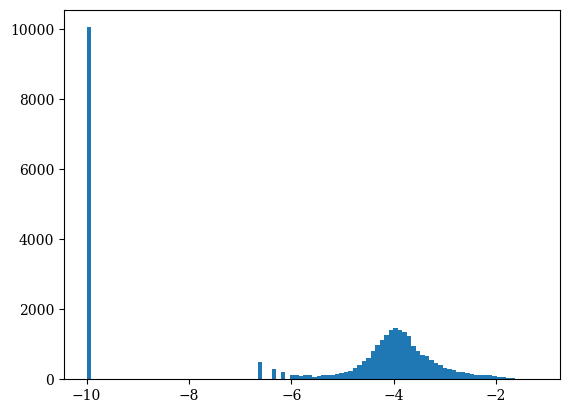

0.659637451171875


In [36]:
plt.hist(utils.to_numpy(l0_transcoder_sparsity), bins=100)
plt.show()
print((l0_transcoder_sparsity>-6).sum().item()/len(l0_transcoder_sparsity))

In [37]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [32]:
l0_transcoder_live = np.arange(len(l0_transcoder_sparsity))[utils.to_numpy(l0_transcoder_sparsity>-6)]

In [33]:
l0_transcoder_live[:50]

array([ 0,  2,  5,  7,  8,  9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 22, 25,
       26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 41, 43, 44, 45, 46,
       49, 50, 51, 53, 54, 56, 57, 58, 60, 62, 63, 64, 65, 68, 69, 71])

## Interpreting first 20 live transcoder features
* 0: ` estimated`
* 2: ` fore`
* 5: ` dr`
* 7: LAEP (but seems to activate on ` at first,`)
* 8: LAEP
* 9: `8`
* 11: BAD FEATURE. activates a ton, promotes whitespace tokens. No clue
* 12: positional, activates around token 2/3/5
* 13: LAEP
* 14: function word after ` With`
* 15: `ups`
* 16: ` politicians`
* 17: LAEP? local context feature? very dense: over 1%
* 18: ` accompanied`
* 19: ` returning` in military context
* 22: tokenization feature? `ro` in "encroachment", `ig` in "pedigree", `ad` in "decadence"
* 25: ` radiation`
* 26: form of verb "run" + ` for`
* 28: form of verb "be" + ` known`
* 29: ` earthquake`

Interpretable features: 14/20

  0%|          | 0/100 [00:00<?, ?it/s]

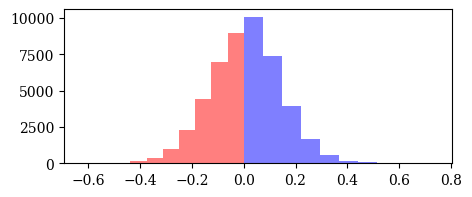

In [34]:
feature_idx = l0_transcoder_live[19]

scores = get_feature_scores(model, l0_transcoder, owt_tokens_torch[:128*100], feature_idx, batch_size=128, use_raw_scores=False)
display(HTML(f"<h2 style='font-family: serif'>Feature {feature_idx}</h2>"))
display_logits_for_feature(model, l0_transcoder, feature_idx)
display_activating_examples_dash(owt_tokens_torch[:128*100], scores)

# Layer 1 transcoder

In [23]:
transcoder_path = "sae_checkpoints/gelu-2l-transcoder/layer_1_transcoder/GELU_2L512W_C4_Code_blocks.1.ln2.hook_normalized_32768"
l1_transcoder = SparseAutoencoder.load_from_pretrained(f"{transcoder_path}.pt").eval()
l1_transcoder_sparsity = torch.load(f"{transcoder_path}_log_feature_sparsity.pt")

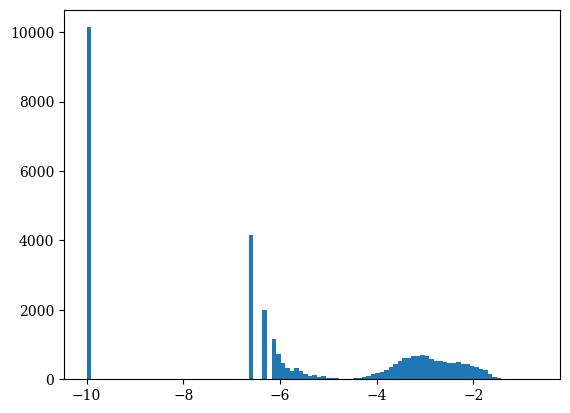

0.44561767578125


In [41]:
plt.hist(utils.to_numpy(l1_transcoder_sparsity), bins=100)
plt.show()
print((l1_transcoder_sparsity>-6).sum().item()/len(l1_transcoder_sparsity))

In [37]:
l1_transcoder_live = np.arange(len(l1_transcoder_sparsity))[utils.to_numpy(l1_transcoder_sparsity>-6)]

In [38]:
l1_transcoder_live[:50]

array([  3,   4,   7,   8,   9,  11,  14,  15,  16,  17,  24,  37,  39,
        41,  42,  43,  44,  46,  48,  49,  50,  52,  53,  57,  59,  61,
        63,  64,  65,  68,  70,  71,  72,  73,  77,  79,  82,  83,  85,
        87,  88,  89,  90,  92,  98,  99, 100, 104, 105, 106])

## Interpreting first 20 live transcoder features
* 3: `2`
* 4: `drug`
* 7: `back` in context of sports (highest activations: "runningback")
* 8: doesn't seem to fire on dataset
* 9: hyphen after BOS -- for some reason, some hyphens after BOS are higher-scoring than others
* 11: ` speaking` (particularly after comma or conjunction)
* 14: space after period
* 15: foreign words? Kinda LAEPy.
* 16: periods in "D.C.", "B.C.", etc
* 17: "take advantage"
* 24: "part of a/the" local context feature
* 37: "a new"
* 39: local context feature for highway directions
* 41: LAEP
* 42: LAEP
* 43: doesn't fire
* 44: LAEP
* 46: polysemantic tokenization feature in middle of words?
* 48: can't
* 49: ` Day` in the context of holidays

Interpretable features: 12/20

  0%|          | 0/100 [00:00<?, ?it/s]

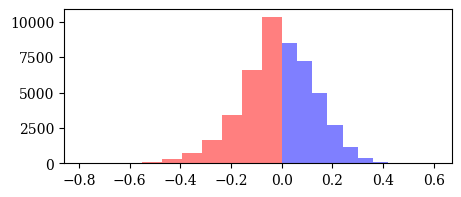

In [39]:
feature_idx = l1_transcoder_live[20]

scores = get_feature_scores(model, l1_transcoder, owt_tokens_torch[:128*100], feature_idx, batch_size=128, use_raw_scores=False)
display(HTML(f"<h2 style='font-family: serif'>Feature {feature_idx}</h2>"))
display_logits_for_feature(model, l1_transcoder, feature_idx)
display_activating_examples_dash(owt_tokens_torch[:128*100], scores)

# Layer 1 SAE

In [24]:
sae_path = "sae_checkpoints/gelu-2l-transcoder/layer_1_sae/GELU_2L512W_C4_Code_blocks.1.hook_mlp_out_32768"
l1_sae = SparseAutoencoder.load_from_pretrained(f"{sae_path}.pt").eval()
l1_sae_sparsity = torch.load(f"{sae_path}_log_feature_sparsity.pt")

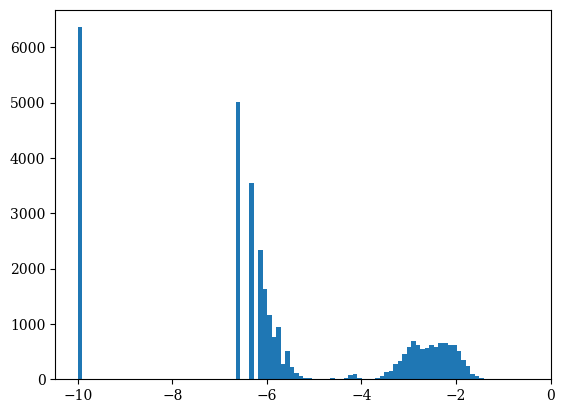

0.423736572265625


In [45]:
plt.hist(utils.to_numpy(l1_sae_sparsity), bins=100)
plt.show()
print((l1_sae_sparsity>-6).sum().item()/len(l1_sae_sparsity))

In [40]:
l1_sae_live = np.arange(len(l1_sae_sparsity))[utils.to_numpy(l1_sae_sparsity>-6)]

In [47]:
l1_sae_live[:50], l1_sae_sparsity[l1_sae_live[:50]]

(array([  2,   3,   4,   7,  12,  13,  15,  16,  19,  21,  22,  24,  28,
         31,  33,  36,  37,  38,  39,  40,  42,  44,  48,  50,  51,  54,
         56,  57,  61,  62,  66,  69,  71,  73,  76,  77,  81,  82,  83,
         84,  85,  88,  89,  91,  93,  94,  98, 101, 102, 104]),
 tensor([-5.7672, -2.6781, -5.9134, -2.7445, -5.9134, -2.9060, -5.8342, -1.7235,
         -5.7092, -3.0016, -2.1785, -2.0373, -2.5053, -2.2584, -2.3889, -2.3561,
         -1.7954, -2.3638, -2.4886, -1.9249, -2.3227, -5.9134, -2.0021, -5.8342,
         -3.1981, -5.7672, -5.9134, -3.1032, -2.0413, -2.3259, -5.7092, -5.9134,
         -1.9774, -3.1357, -5.9134, -3.0206, -2.1369, -2.7354, -1.8508, -5.4984,
         -5.8342, -5.7092, -2.4346, -2.1669, -2.5423, -3.1467, -3.1989, -2.2183,
         -3.2435, -4.2680]))

## Interpreting live features
* 2: doesn't fire
* 3: "like this"
* 4: doesn't fire
* 7: ` parking` (predicts ` lot`)
* 12: doesn't fire
* 13: Pope, Kim, and Lee
* 15: doesn't fire
* 16: LAEP
* 19: doesn't fire
* 21: local context feature for setting things aside in recipes
* 22: brutal, harsh, extreme
* 24: "are typically" and some other polysemantic stuff
* 28: ` before` or ` after` in the context of sports

# Circuit analysis: SAE feature 21

We'll now see how to do circuit analysis on this multi-layer model, by reverse-engineering a layer 1 MLP-out SAE feature.

The feature in question will be SAE feature 21. The first step is to create a `Feature` object representing this SAE feature.

In [43]:
my_feature = Feature(
    layer = 1,
    sublayer = 'mlp_out',
    token = -1,

    vector = l1_sae.W_enc[:, 21], # encoder vector corresponding to this feature
    
    feature_type = "sae",
    feature_idx = 21,
)

Most of the above fields should be self-explanatory. One thing worth noting is what `token = -1` means. In the circuit analysis process, we'll be analyzing what causes the feature to fire *on a given token* for a given prompt. `token = -1` means that when we perform the circuit analysis, we should perform the analysis with respect to the feature's activation *on the last token in the prompt* (because `-1` means the last token in the prompt; `-2` means the penultimate; etc.).

There's a way to concisely represent the `Feature` object that we just created. You can see this representation below:

In [44]:
my_feature

sae1[21]@-1

What this means is that the feature is an SAE feature at layer 1; the feature index is 21; and the feature is located at token -1. We'll see similar representations for transcoder features (and attention-mediated transcoder features) later on, when we do the reverse engineering.

Now, what are the top activating examples for this feature?

  0%|          | 0/100 [00:00<?, ?it/s]

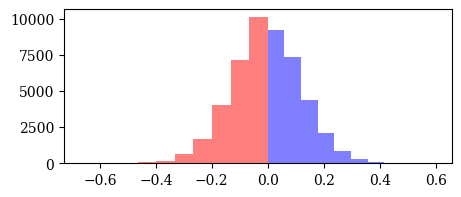

In [42]:
sae_feature_idx = 21

scores = get_feature_scores(model, l1_sae, owt_tokens_torch[:128*100], sae_feature_idx, batch_size=128, use_raw_scores=False)
display(HTML(f"<h2 style='font-family: serif'>Feature {sae_feature_idx}</h2>"))
display_logits_for_feature(model, l1_sae, sae_feature_idx)
display_activating_examples_dash(owt_tokens_torch[:128*100], scores)

Well, this is an interesting feature! Top activating examples include example 8155, token 58 and example 7872, token 68. Let's start by analyzing the latter example.

## Reverse-engineering walkthrough for example 7872, token 68

First, we'll run the model on the prompt and then store the activations in a cache.

In [45]:
prompt = owt_tokens_torch[7872, :68+1]
_, cache = model.run_with_cache(prompt) # run the model on the prompt

prompt_tokens = model.to_str_tokens(prompt) # divide the prompt into str tokens
print(prompt_tokens)

['<|BOS|>', '/', '2', ' teaspoon', ' salt', '\n', '\n', '1', '/', '2', ' teaspoon', ' c', 'umin', '\n', '\n', '1', ' teaspoon', ' chili', ' powder', '\n', '\n', '1', ' teaspoon', ' pap', 'rika', '\n', '\n', '1', '/', '2', ' teaspoon', ' crushed', ' red', ' pepper', '\n', '\n', 'Inst', 'ructions', '\n', '\n', 'Pre', 'heat', ' a', ' sa', 'ut', 'é', ' pan', ' with', ' 1', ' tablespoon', ' olive', ' oil', ' and', ' cook', ' chor', 'izo', ' until', ' firm', ',', ' turning', ' frequently', ' to', ' avoid', ' burning', '.', ' Set', ' aside', ' to', ' cool']


### Understanding computational paths

Now, we'll find the OV circuit computational paths that (according to a greedy search) have the most effect on the SAE feature. To do this, we'll use the `greedy_get_top_paths()` function.

In [52]:
all_paths = greedy_get_top_paths(model, [l0_transcoder, l1_transcoder], cache, my_feature, num_iters=4, num_branches=10)

The arguments to this function are, in order:
* The model that we're investigating.
* A list of transcoders at each layer.
* The cache of activations that we get from running our model.
* Our feature that we want to reverse-engineer.
* `num_iters`: How many steps we should take in the computational path search process.
* `num_branches`: How many computational paths we should consider at each step.

Let's print out the computational paths that have been found.

In [54]:
print_all_paths(all_paths)

--- Paths of size 2 ---
Path [0][0]: sae1[21]@-1 <- tc1[24950]@-1: 3.7
Path [0][1]: sae1[21]@-1 <- tc1[32180]@-1: 1.4
Path [0][2]: sae1[21]@-1 <- tc1[31446]@-1: 0.82
Path [0][3]: sae1[21]@-1 <- tc1[27934]@-1: 0.76
Path [0][4]: sae1[21]@-1 <- tc1[27478]@-1: 0.66
Path [0][5]: sae1[21]@-1 <- tc1[31524]@-1: 0.24
Path [0][6]: sae1[21]@-1 <- tc1[9571]@-1: 0.22
Path [0][7]: sae1[21]@-1 <- tc1[6767]@-1: 0.12
Path [0][8]: sae1[21]@-1 <- tc1[27291]@-1: 0.095
Path [0][9]: sae1[21]@-1 <- tc1[32147]@-1: 0.081
--- Paths of size 3 ---
Path [1][0]: sae1[21]@-1 <- tc1[24950]@-1: 3.7 <- tc0[5785]@-1: 0.99
Path [1][1]: sae1[21]@-1 <- tc1[24950]@-1: 3.7 <- tc1[24950]attn1[0]@66: 0.84
Path [1][2]: sae1[21]@-1 <- tc1[27478]@-1: 0.66 <- tc0[12755]@-1: 0.65
Path [1][3]: sae1[21]@-1 <- tc1[24950]@-1: 3.7 <- tc0[12755]@-1: 0.64
Path [1][4]: sae1[21]@-1 <- tc1[24950]@-1: 3.7 <- tc1[24950]attn1[0]@68: 0.62
Path [1][5]: sae1[21]@-1 <- tc1[24950]@-1: 3.7 <- tc1[24950]attn1[2]@68: 0.59
Path [1][6]: sae1[21]@-1 <- tc

Wow, that's a lotta output. Let's take a look at how to read this. As an example, we'll focus on this line:

`Path [3][0]: sae1[21]@-1 <- tc1[24950]@-1: 3.7 <- tc1[24950]attn1[0]@66: 0.84 <- tc0[12755]@66: 0.47 <- tc0[12755]embed@66: 0.31`

We can break this down as follows:
* The `Path [3][0]:` bit tells us that we can access this computational path by indexing into our `all_paths` variable (where we stored the computational paths) as `all_paths[3][0]`.
* The rest of the line is a representation of the computational path. Importantly, *later-layer features are at the left; earlier-layer features are at the right*. As an example, the layer 1 feature `tc1[24950]@-1: 3.7` comes to the left of the layer 0 feature `tc0[12755]@66: 0.47`. The left-pointing `<-` arrows serve to clarify this.
* Looking more closely at the feature `tc1[24950]@-1: 3.7`: this represents feature 24950 in the layer 1 transcoder at token -1 (the last token in the prompt), with a feature attribution score of 3.7.
* Similarly, `tc0[12755]@66: 0.47` represents feature 12755 in the layer 0 transcoder at token 66, with a feature attribution score of 0.47.
* Getting a bit more complex: `tc1[24950]attn1[0]@66: 0.84` represents an *attention head's contribution to a transcoder feature*. In particular, this represents the OV circuit contribution of head 0 in attention layer 1 to feature 24950 in the layer 1 transcoder at token 66.
    * <details> <summary style='cursor: pointer; text-decoration: underline; color: #000055'>Click to view an optional technical note</summary>You might be wondering: if we already know that this attention head is contributing to transcoder feature 24950 at layer 1 (from our computational path), then why not just write this feature as <code>attn1[0]@66</code>? Why go to the seemingly-redundant trouble of writing <code>tc1[24950]attn1[0]@66</code> instead? The answer is that <i>each feature specifies a unique direction in activation space</i>. Now, transcoder features like <code>tc1[24950]</code> always have unique directions associated with them (i.e. the encoder direction). But the direction associated with an attention head depends on the feature that the attention head contributes to. For example, the feature <code>tc1[31446]attn1[2]</code> has a different direction in activation space than the feature <code>tc1[24950]attn1[2]</code>, even though the same attention head is being used. (Mathematically, this is because the feature direction associated with the attention head is given by the <i>pullback</i> of the transcoder feature vector by the attention head's OV matrix.)</details>
* The last feature in the computational path, `tc0[12755]embed@66: 0.31`, represents the *contribution of the initial token embeddings to transcoder feature 12755 in layer 0*. Note that the contribution of `tc0[12755]@66: 0.47` is greater than `tc0[12755]embed@66: 0.31`. This is because the embeddings don't just contribute to the transcoder feature via the direct path; instead, there are also contributions to the transcoder feature via attention heads.

There's also one last piece of notation to go over, which doesn't appear in this computational path, but does appear in others:
* When we see a feature like `tc0[12755]attn0[6]embed@53: 0.079`, similarly to what we've seen before, this refers to the direct contribution of the token embeddings to the feature `tc0[12755]attn0[6]` -- which is the feature corresponding to the contribution of layer 0 attention head 6 to layer 0 transcoder feature 12755.

Whew. That was a lot, but hopefully, you're starting to make sense of all this. (Hopefully.)

### Wait, what do feature attribution scores mean in the first place?

One question you might be wondering: in a computational path like 

`Path [2][0]: sae1[21]@-1 <- tc1[24950]@-1: 3.7 <- tc0[5785]@-1: 0.99 <- tc0[5785]embed@-1: 0.99`

what does it actually mean for the "contribution" of `tc0[5785]embed@-1` to be 0.99? What it means is this: if you were to zero ablate all of the contribution of the token embeddings at token -1 to transcoder feature `tc0[5785]`, followed by propagating this ablation upward through the computational path, then this would cause the activation of the original SAE feature `sae1[21]@-1` to decrease by 0.99.

### Looking at sub-computational-paths

One thing worth noting is that *each computational path is just a list of `Feature` objects*. As an example of what you can do with this: say that we see the line of output

`Path [0][1]: sae1[21]@-1 <- tc1[32180]@-1: 1.4`

and are curious about specifically the computational paths that contribute to this last feature. Then we can do the following:

In [55]:
sub_paths = greedy_get_top_paths(model, [l0_transcoder, l1_transcoder], cache, all_paths[0][1][-1], num_iters=4, num_branches=5)
# all_paths[0][1][-1]: the last feature in computational path [0][1]

In [56]:
print_all_paths(sub_paths)

--- Paths of size 2 ---
Path [0][0]: tc1[32180]@-1: 1.4 <- tc0[5785]@-1: 0.46
Path [0][1]: tc1[32180]@-1: 1.4 <- tc0[12755]@-1: 0.32
Path [0][2]: tc1[32180]@-1: 1.4 <- tc1[32180]attn1[0]@68: 0.31
Path [0][3]: tc1[32180]@-1: 1.4 <- tc1[32180]attn1[0]@66: 0.28
Path [0][4]: tc1[32180]@-1: 1.4 <- tc1[32180]attn0[2]@67: 0.14
--- Paths of size 3 ---
Path [1][0]: tc1[32180]@-1: 1.4 <- tc0[5785]@-1: 0.46 <- tc0[5785]embed@-1: 0.46
Path [1][1]: tc1[32180]@-1: 1.4 <- tc0[12755]@-1: 0.32 <- tc0[12755]embed@-1: 0.22
Path [1][2]: tc1[32180]@-1: 1.4 <- tc1[32180]attn1[0]@66: 0.28 <- tc0[12755]@66: 0.2
Path [1][3]: tc1[32180]@-1: 1.4 <- tc1[32180]attn0[2]@67: 0.14 <- tc0[32180]embed@67: 0.14
Path [1][4]: tc1[32180]@-1: 1.4 <- tc1[32180]attn1[0]@68: 0.31 <- tc0[12755]@68: 0.12
--- Paths of size 4 ---
Path [2][0]: tc1[32180]@-1: 1.4 <- tc1[32180]attn1[0]@66: 0.28 <- tc0[12755]@66: 0.2 <- tc0[12755]embed@66: 0.14
Path [2][1]: tc1[32180]@-1: 1.4 <- tc1[32180]attn1[0]@68: 0.31 <- tc0[12755]@68: 0.12 <- tc

This allows you to hone in on specific subcircuits that you might be interested in.

**Important**: when we look at subcircuits in this way, the contribution scores that you see are all relative to the original computational path that we took our feature `tc1[32180]@-1: 1.4`. As such, when we see the output 

`Path [2][0]: tc1[32180]@-1: 1.4 <- tc1[32180]attn1[0]@66: 0.28 <- tc0[12755]@66: 0.2 <- tc0[12755]embed@66: 0.14`

what this means is that `tc0[12755]embed@66: 0.14` contributes 0.14 via this computational path *to the original SAE feature `sae1[21]@-1` (not shown here).*

### Interpreting circuits

Now that we know how to read computational paths, let's start interpreting our circuit. For convenience, I'll show you again the previous list of top computational paths:

In [54]:
print_all_paths(all_paths)

--- Paths of size 2 ---
Path [0][0]: sae1[21]@-1 <- tc1[24950]@-1: 3.7
Path [0][1]: sae1[21]@-1 <- tc1[32180]@-1: 1.4
Path [0][2]: sae1[21]@-1 <- tc1[31446]@-1: 0.82
Path [0][3]: sae1[21]@-1 <- tc1[27934]@-1: 0.76
Path [0][4]: sae1[21]@-1 <- tc1[27478]@-1: 0.66
Path [0][5]: sae1[21]@-1 <- tc1[31524]@-1: 0.24
Path [0][6]: sae1[21]@-1 <- tc1[9571]@-1: 0.22
Path [0][7]: sae1[21]@-1 <- tc1[6767]@-1: 0.12
Path [0][8]: sae1[21]@-1 <- tc1[27291]@-1: 0.095
Path [0][9]: sae1[21]@-1 <- tc1[32147]@-1: 0.081
--- Paths of size 3 ---
Path [1][0]: sae1[21]@-1 <- tc1[24950]@-1: 3.7 <- tc0[5785]@-1: 0.99
Path [1][1]: sae1[21]@-1 <- tc1[24950]@-1: 3.7 <- tc1[24950]attn1[0]@66: 0.84
Path [1][2]: sae1[21]@-1 <- tc1[27478]@-1: 0.66 <- tc0[12755]@-1: 0.65
Path [1][3]: sae1[21]@-1 <- tc1[24950]@-1: 3.7 <- tc0[12755]@-1: 0.64
Path [1][4]: sae1[21]@-1 <- tc1[24950]@-1: 3.7 <- tc1[24950]attn1[0]@68: 0.62
Path [1][5]: sae1[21]@-1 <- tc1[24950]@-1: 3.7 <- tc1[24950]attn1[2]@68: 0.59
Path [1][6]: sae1[21]@-1 <- tc

One interesting pattern to note: it looks like `tc0[12755]` plays a decently-important role across a number of different tokens. Let's see what examples cause it to activate. 

  0%|          | 0/100 [00:00<?, ?it/s]

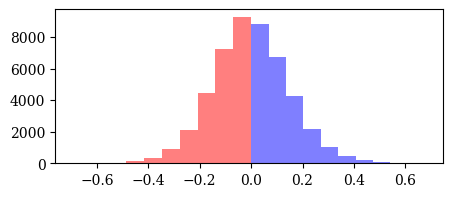

In [60]:
layer = 0
tc_feature_idx = 12755

tc = l1_transcoder if layer == 1 else l0_transcoder

tc_scores = get_feature_scores(model, tc, owt_tokens_torch[:128*100], tc_feature_idx, batch_size=128, use_raw_scores=False)
display_logits_for_feature(model, tc, tc_feature_idx)
display_activating_examples_dash(owt_tokens_torch[:128*100], tc_scores, header_level=None)

It looks like this layer 0 transcoder feature activates on similar examples (the same "recipe" theme) as the original layer 1 SAE feature. And looking at the logits that are most promoted, we can see a clear cooking theme. Interesting!

Now, for some input-independent information, let's see what the de-embeddings are for this transcoder feature.

In [63]:
display_deembeddings_for_transcoder_feature(model, l0_transcoder, 12755, k=12)

Unfortunate: doesn't look like this is too interpretable.

But we also frequently see in our computational paths the feature `tc0[12755]attn0[6]embed`. What happens if we take the de-embedding of the transcoder feature 12755 through head 6 of layer 0 attention?

In [69]:
display_deembeddings_for_transcoder_feature(model, l0_transcoder, 12755, attn_layer=0, attn_head=6, k=12)

Aha! Tons of cooking/recipe-related tokens! Note that some of the harder-to-interpret tokens -- like `poons`, `isk`, `Comb`, and ` spat` -- are parts of multi-token words that you'd frequently find in recipes, like `tablespoons`, ` Whisk`, `Combine`, and ` spatula`, as we see below.

In [72]:
model.to_str_tokens('tablespoons'), model.to_str_tokens(' Whisk'), model.to_str_tokens('Combine'), model.to_str_tokens(' spatula')

(['<|BOS|>', 'tables', 'poons'],
 ['<|BOS|>', ' Wh', 'isk'],
 ['<|BOS|>', 'Comb', 'ine'],
 ['<|BOS|>', ' spat', 'ula'])

There are other features and computational paths that you can examine, but now, you should (hopefully) have a good idea of how to use these tools. As another example, let's perform a similar procedure on example 8155, token 59.

## Example 8155, token 59 

First, run our model on the prompt and store the activations.

In [73]:
prompt = owt_tokens_torch[8155, :59+1]
_, cache = model.run_with_cache(prompt) # run the model on the prompt

prompt_tokens = model.to_str_tokens(prompt) # divide the prompt into str tokens
print(prompt_tokens)

['<|BOS|>', ' simmer', ' qu', 'ino', 'a', ' for', ' 1', '5', ' minutes', ' or', ' until', ' water', ' is', ' absorbed', ' and', ' qu', 'ino', 'a', ' is', ' tender', '.', ' During', ' the', ' last', ' 3', ' minutes', ' of', ' cooking', ' add', ' unc', 'ook', 'ed', ' shrimp', ' and', ' sliced', ' chor', 'izo', ' sausage', ' to', ' saucepan', ' and', ' stir', '.', '\n', '\n', 'Once', ' done', ' let', ' qu', 'ino', 'a', ' rest', ' in', ' saucepan', ',', ' covered', ',', ' for', ' 5', ' minutes']


Next, get our top paths on the prompt.

In [74]:
all_paths = greedy_get_top_paths(model, [l0_transcoder, l1_transcoder], cache, my_feature, num_iters=4, num_branches=10)
print_all_paths(all_paths)

--- Paths of size 2 ---
Path [0][0]: sae1[21]@-1 <- tc1[24950]@-1: 3.4
Path [0][1]: sae1[21]@-1 <- tc1[32180]@-1: 1.9
Path [0][2]: sae1[21]@-1 <- tc1[10923]@-1: 1.8
Path [0][3]: sae1[21]@-1 <- tc1[5629]@-1: 0.45
Path [0][4]: sae1[21]@-1 <- tc1[31524]@-1: 0.41
Path [0][5]: sae1[21]@-1 <- tc1[32019]@-1: 0.35
Path [0][6]: sae1[21]@-1 <- tc1[31446]@-1: 0.32
Path [0][7]: sae1[21]@-1 <- tc1[27934]@-1: 0.28
Path [0][8]: sae1[21]@-1 <- tc1[17883]@-1: 0.068
Path [0][9]: sae1[21]@-1 <- tc1[28160]@-1: 0.066
--- Paths of size 3 ---
Path [1][0]: sae1[21]@-1 <- tc1[32180]@-1: 1.9 <- tc0[14540]@-1: 1.0
Path [1][1]: sae1[21]@-1 <- tc1[24950]@-1: 3.4 <- tc1[24950]attn1[2]@57: 1.0
Path [1][2]: sae1[21]@-1 <- tc1[10923]@-1: 1.8 <- tc0[14540]@-1: 0.85
Path [1][3]: sae1[21]@-1 <- tc1[24950]@-1: 3.4 <- tc1[24950]attn1[0]@57: 0.81
Path [1][4]: sae1[21]@-1 <- tc1[24950]@-1: 3.4 <- tc1[24950]attn1[0]@55: 0.71
Path [1][5]: sae1[21]@-1 <- tc1[24950]@-1: 3.4 <- tc0[12755]@-1: 0.65
Path [1][6]: sae1[21]@-1 <- tc1[

In addition to the previously-seen `tc0[12755]` and `tc0[12755]attn0` features, we also see features like `tc0[14540]` and `tc0[27797]`. What do these features activate on?

#### `tc0[14540]`

  0%|          | 0/100 [00:00<?, ?it/s]

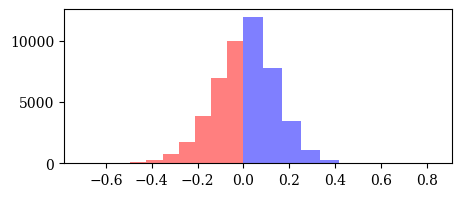

In [78]:
layer = 0
tc_feature_idx = 14540

tc = l1_transcoder if layer == 1 else l0_transcoder

scores = get_feature_scores(model, tc, owt_tokens_torch[:128*100], tc_feature_idx, batch_size=128, use_raw_scores=False)
display_logits_for_feature(model, tc, tc_feature_idx)
display_activating_examples_dash(owt_tokens_torch[:128*100], scores, header_level=None)

In [76]:
display_deembeddings_for_transcoder_feature(model, l0_transcoder, 14540, k=15)

Looks like this feature most strongly fires on ` minutes` and related tokens, with a sharp drop-off after that. Makes sense, because the token that we're looking at in this example is ` minutes`.

In [79]:
prompt_tokens[-1]

' minutes'

### `tc0[27797]`

  0%|          | 0/100 [00:00<?, ?it/s]

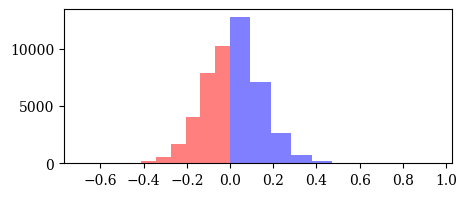

In [80]:
layer = 0
tc_feature_idx = 27797

tc = l1_transcoder if layer == 1 else l0_transcoder

scores = get_feature_scores(model, tc, owt_tokens_torch[:128*100], tc_feature_idx, batch_size=128, use_raw_scores=False)
display_logits_for_feature(model, tc, tc_feature_idx)
display_activating_examples_dash(owt_tokens_torch[:128*100], scores, header_level=None)

In [81]:
display_deembeddings_for_transcoder_feature(model, l0_transcoder, 27797, k=10)

Aha: this feature fires on ` for`! And indeed, what's the penultimate token of the prompt?

In [82]:
prompt_tokens[57]

' for'

### `tc1[24950]`

So far, we've been looking at layer 0 transcoder features that are important to example 8155 token 59 and not the previously-investigated example 7872 token 68. But upon further comparison of the computational graphs, we see that the layer 1 transcoder feature `tc1[24950]` is important in both cases. What's the deal with this feature? Let's first look at maximally-activating examples, and then do some subcircuit analysis.

  0%|          | 0/100 [00:00<?, ?it/s]

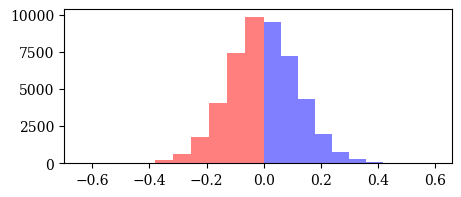

In [83]:
layer = 1
tc_feature_idx = 24950

tc = l1_transcoder if layer == 1 else l0_transcoder

scores = get_feature_scores(model, tc, owt_tokens_torch[:128*100], tc_feature_idx, batch_size=128, use_raw_scores=False)
display_logits_for_feature(model, tc, tc_feature_idx)
display_activating_examples_dash(owt_tokens_torch[:128*100], scores, header_level=None)

In [85]:
sub_paths = greedy_get_top_paths(model, [l0_transcoder, l1_transcoder], cache, all_paths[0][0][-1], num_iters=4, num_branches=10)
print_all_paths(sub_paths)

--- Paths of size 2 ---
Path [0][0]: tc1[24950]@-1: 3.4 <- tc1[24950]attn1[2]@57: 1.0
Path [0][1]: tc1[24950]@-1: 3.4 <- tc1[24950]attn1[0]@57: 0.81
Path [0][2]: tc1[24950]@-1: 3.4 <- tc1[24950]attn1[0]@55: 0.71
Path [0][3]: tc1[24950]@-1: 3.4 <- tc0[12755]@-1: 0.65
Path [0][4]: tc1[24950]@-1: 3.4 <- tc0[14540]@-1: 0.45
Path [0][5]: tc1[24950]@-1: 3.4 <- tc1[24950]attn1[0]@59: 0.35
Path [0][6]: tc1[24950]@-1: 3.4 <- tc1[24950]attn1[0]@45: 0.29
Path [0][7]: tc1[24950]@-1: 3.4 <- tc1[24950]attn1[0]@47: 0.28
Path [0][8]: tc1[24950]@-1: 3.4 <- tc1[24950]attn1[0]@58: 0.27
Path [0][9]: tc1[24950]@-1: 3.4 <- tc1[24950]attn1[7]@47: 0.21
--- Paths of size 3 ---
Path [1][0]: tc1[24950]@-1: 3.4 <- tc1[24950]attn1[2]@57: 1.0 <- tc0[27797]@57: 0.48
Path [1][1]: tc1[24950]@-1: 3.4 <- tc0[14540]@-1: 0.45 <- tc0[14540]embed@-1: 0.45
Path [1][2]: tc1[24950]@-1: 3.4 <- tc1[24950]attn1[0]@55: 0.71 <- tc0[12755]@55: 0.39
Path [1][3]: tc1[24950]@-1: 3.4 <- tc1[24950]attn1[0]@57: 0.81 <- tc0[12755]@57: 0.39

Zooming in on this subcircuit reveals a couple other layer 0 transcoder features, like `tc0[19178]` and `tc0[4569]`. What's their deal?

In [87]:
display_deembeddings_for_transcoder_feature(model, l0_transcoder, 19178, k=10)

Looks like `tc0[19178]` is another ` for` feature. What about `tc0[4569]`?

In [88]:
display_deembeddings_for_transcoder_feature(model, l0_transcoder, 4569, k=10)